In [1]:
%pylab inline
import torch

Populating the interactive namespace from numpy and matplotlib


In [2]:
figsize(10, 8)
plt.style.use(['dark_background'])

In [3]:
import pickle

corpus_text = pickle.load(
    open("corpus_text.pickle", "rb")
)

In [4]:
word2id, id2word = {}, {}

uniques = set()
for words in corpus_text:
    for w in words:
        uniques.add(w)

count_id = 0
for word in uniques:
    word2id[word] = count_id
    id2word[count_id] = word
    count_id += 1

In [5]:
id2word[23]

'projetou'

In [6]:
len(uniques), len(corpus_text)

(618, 61)

In [7]:
window = 2
pair_ids = []

text_size = len(corpus_text)

corpus_text = np.array(corpus_text)
mask = np.array([i for i in range(-window, window+1) if i is not 0])

for paragraph in corpus_text:
    paragraph = np.array(paragraph)
    text_size = len(paragraph)

    for center_word in range(window, text_size-window):
        center_word_id = word2id[paragraph[center_word]]
        for i in paragraph[mask + center_word]:
            context_word_id = word2id[i]
            pair_ids.append([center_word_id, context_word_id])

pair_ids = np.array(pair_ids)

In [8]:
from IPython.display import Markdown

In [9]:
ex_out = "|central | contexto | central | contexto |\n|--|--|--|--|\n"
for i in range(95, 106):
    w0, w1 = pair_ids[i]
    ex_out += f"|{w0} | {w1} | {id2word[w0]} | {id2word[w1]}|\n"

Markdown(ex_out)

|central | contexto | central | contexto |
|--|--|--|--|
|345 | 318 | máquina | desempenhando|
|140 | 15 | turing | computação|
|140 | 345 | turing | máquina|
|140 | 318 | turing | desempenhando|
|140 | 536 | turing | papel|
|318 | 345 | desempenhando | máquina|
|318 | 140 | desempenhando | turing|
|318 | 536 | desempenhando | papel|
|318 | 149 | desempenhando | importante|
|536 | 140 | papel | turing|
|536 | 318 | papel | desempenhando|


In [10]:
class SkipGram(torch.nn.Module):
    def __init__(self, vocab_size, emb_size):
        super(SkipGram, self).__init__()
        
        self.embeddings = torch.nn.Embedding(vocab_size, emb_size)
        
        self.linear0 =  torch.nn.Linear(emb_size, 512)
        self.linear1 = torch.nn.Linear(512, vocab_size)

        self.log_softmax = torch.nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        out = self.embeddings(x)

        out = self.linear0(out)
        out = self.linear1(out)
        
        out = self.log_softmax(out)
        return out
    
    def get_word_emb(self, word_id):
        word = torch.LongTensor([word_id])
        return self.embeddings(word).view(1, -1)

In [11]:
skipgram = SkipGram(len(uniques), 10)

In [12]:
teste_data = torch.LongTensor([pair_ids[3000, 0]])
res = skipgram(teste_data).argmax().item()
id2word[res], id2word[pair_ids[3000, 1]]

('conceito', 'durante')

In [13]:
from torch.utils.data import Dataset, DataLoader

In [14]:
class Dataset(Dataset):
    def __init__(self, obj):
        self.len = len(obj)
        self.x = torch.LongTensor(obj[:, 0])
        self.y = torch.LongTensor(obj[:, 1])
    def __getitem__(self, index):
        return (self.x[index], self.y[index])
    def __len__(self):
        return self.len

In [15]:
dataset = Dataset(pair_ids)
data = DataLoader(dataset=dataset, batch_size=1000, shuffle=True)

In [16]:
nll_loss = torch.nn.NLLLoss()
optimizer = torch.optim.SGD(skipgram.parameters(), lr=0.001)
losses = []
for epoch in range(2501):
    for X, Y in data:
        optimizer.zero_grad()
        
        out_prob = skipgram(X)
        loss = nll_loss(out_prob, Y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    
    if epoch % 500 == 0:
        print(f"{epoch:<2} - {loss.item():.3f}")

0  - 6.489
500 - 6.287
1000 - 6.162
1500 - 6.018
2000 - 5.975
2500 - 5.873


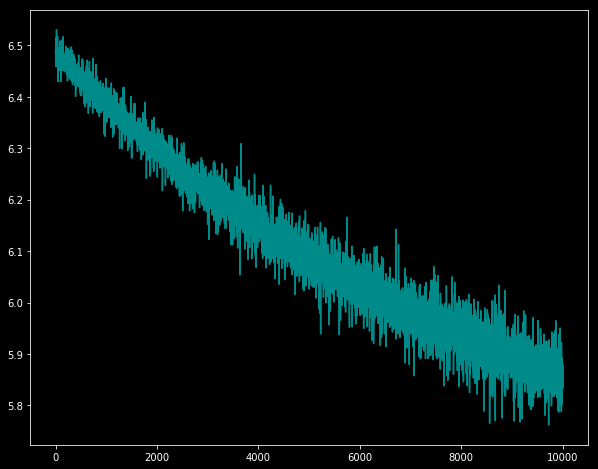

In [17]:
fig = figure()
ax = fig.gca()
ax.plot(losses, c="darkcyan")
savefig("../images/word2vec-skipgram-loss.png", dpi="figure", transparent=True)

In [18]:
_pos = 28
teste_data = torch.LongTensor(pair_ids[_pos][0])
target_data = torch.LongTensor(pair_ids[_pos][1])
res = skipgram(torch.LongTensor([23])).argmax().item()
print(f"data:{[id2word[_pos] ]} | target: {id2word[pair_ids[_pos][1]]}")
print(f"{id2word[res]}")


data:['estabelecido'] | target: cheshire
turing


In [19]:
skipgram.get_word_emb(_pos).detach().numpy()

array([[ 0.74846876, -0.38319612, -2.0393155 ,  0.7892148 , -0.30229536,
         0.08340574,  0.36708632,  1.4052113 , -0.7146022 ,  0.03139668]],
      dtype=float32)

In [20]:
from sklearn.decomposition import PCA
import pandas as pd

In [21]:
dataf = pd.DataFrame({
    "words":list(uniques),
    "id": [word2id[i] for i in uniques],
    "emb": [skipgram.get_word_emb(word2id[i]).detach().numpy()[0] for i in uniques],
    "x" : [0]*len(uniques),
    "y": [0]*len(uniques)
})

In [22]:
dataf.head()

,words,id,emb,x,y
0,seção,0,"[0.18961886, 3.1793153, 0.58098125, 0.33478755...",0,0
1,ingerida,1,"[0.30912983, -0.44858375, 0.21493591, -1.71769...",0,0
2,baronete,2,"[-1.4124938, -0.12927267, -0.45383695, -0.2109...",0,0
3,constata,3,"[-6.4023943e-06, 1.689993, 0.5669997, -1.05180...",0,0
4,resultado,4,"[0.58150846, 1.0726862, -0.020895923, -0.09269...",0,0


In [23]:
pca = PCA(n_components=2)
a = np.array([skipgram.get_word_emb(word2id[i]).detach().numpy()[0] for i in uniques],)
XY = pca.fit_transform(a)

In [24]:
dataf["x"] = XY[:, 0]
dataf["y"] = XY[:, 1]
dataf.head()

,words,id,emb,x,y
0,seção,0,"[0.18961886, 3.1793153, 0.58098125, 0.33478755...",1.084898,1.929788
1,ingerida,1,"[0.30912983, -0.44858375, 0.21493591, -1.71769...",-0.243921,-1.393110
2,baronete,2,"[-1.4124938, -0.12927267, -0.45383695, -0.2109...",-1.546296,-0.275127
3,constata,3,"[-6.4023943e-06, 1.689993, 0.5669997, -1.05180...",0.637173,0.069856
4,resultado,4,"[0.58150846, 1.0726862, -0.020895923, -0.09269...",0.070311,1.021042


In [25]:
import altair as alt

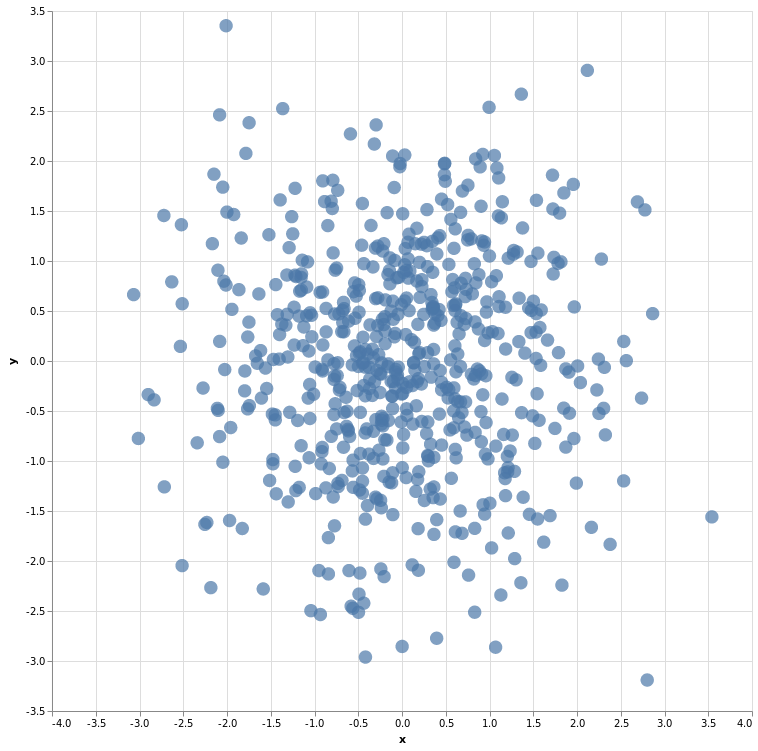

In [26]:
alt.themes.enable('opaque')
base = alt.Chart(dataf).properties(
        width=700,
        height=700
    )

base.mark_circle(size=180).encode(x="x", y="y", tooltip="words")

In [27]:
from knn_eucl_cos import knn

In [28]:
w = word2id["cianeto"]

matrix = np.array([skipgram.get_word_emb(word2id[i]).detach().numpy()[0] for i in uniques])
result_pos, result_values = knn(dataf.emb, pos=w, n=10)
result_p_eucl, result_v_eucl = knn(dataf.emb, pos=w, n=10, func="eucl")

mark = "| rank sim cos| - | rank dist eucl | - |\n|--|--|--|--|\n"
for i, j, k, l in zip(result_pos, result_values, result_p_eucl, result_v_eucl):
    mark += f"|{id2word[i]:<13} | {j:.5f} | {id2word[k]:<13} | {l:.5f}|\n"

Markdown(mark)

| rank sim cos| - | rank dist eucl | - |
|--|--|--|--|
|muitos        | 0.14544 | muitos        | 0.07375|
|poderia       | 0.26087 | code          | 0.08692|
|ceruzzi       | 0.28141 | ceruzzi       | 0.08939|
|code          | 0.28206 | condados      | 0.09595|
|britânica     | 0.28430 | mortem        | 0.09709|
|mortem        | 0.33544 | atos          | 0.10284|
|condenado     | 0.33660 | teórica       | 0.10357|
|comerciantes  | 0.33929 | condenado     | 0.10376|
|cabeceira     | 0.34548 | rápido        | 0.10433|
|condados      | 0.36041 | prazer        | 0.10648|


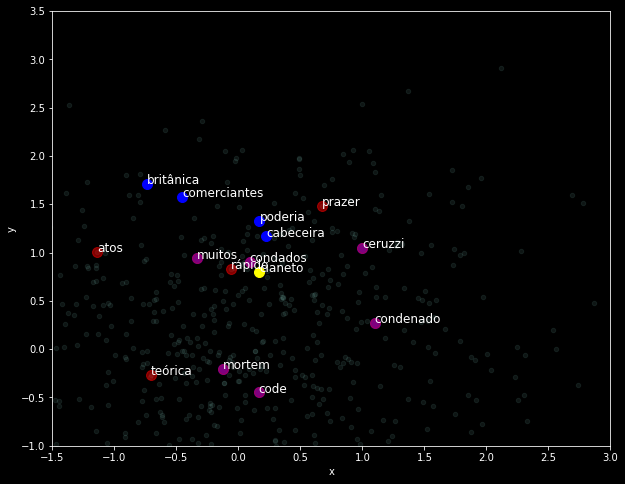

In [32]:
fig = figure()
ax = fig.gca()
dataf.plot.scatter("x", "y", ax=ax, alpha=0.1)
dataf.query(f"id == {w}").plot.scatter("x", "y", ax=ax, s=100, c="yellow")
dataf[dataf['id'].isin(result_pos)].plot.scatter("x", "y", ax=ax, s=100, c="blue")
dataf[dataf['id'].isin(result_p_eucl)].plot.scatter("x", "y", ax=ax, s=100, c="red", alpha=0.5)

for i in set(result_p_eucl.tolist() + result_pos.tolist() + [w]):
    coord = dataf.query(f"id=={i}")
    ax.annotate(coord.words.values[0],(coord.x,coord.y), size=12)

ax.set_xlim(-1.5, 3)
ax.set_ylim(-1, 3.5)
savefig("../images/word2vec-skipgram-rank.png", dpi="figure", transparent=True)